# Spectral Analysis for Zabuyelite

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm import tqdm
import swordfish as sf
from WIMpy import DMUtils as DMU
from scipy.interpolate import interp1d

# rc('text', usetex=True)
# rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
# rc('font',**{'family':'serif','serif':['cmr']})
%matplotlib inline

Not totally sure how to calculate the rate here. I'm going to assume that the rate for a target with multiple nuclei is given by

$$ \frac{dR}{dE} = \sum_i A_i\frac{dR_i}{dE}$$

where $i$ refers to the different nuclei and $A_i$ is their by mass contribution to the total nuclei. I'll therefore calculate the spectra as a function of track length with 

$$ \frac{dR}{dE} = \sum_i A_i\frac{dR_i}{dE}\frac{dE}{dx_i}$$

where the $dR/dx_i$ refers to the differential track length from scattering off a particular nuclei.

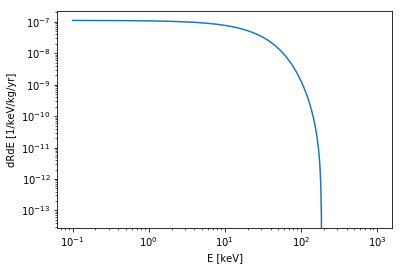

In [17]:
# Zabuyelite is Li2CO3 therefore we need to some over several elements to get the signal
# Here we give the number of protons and neutrons in lithium, carbon, and oxygen
# in that order
nuclei_Zab = ["Li", "C", "O"]
Zab_abun = np.array([0.189,0.162,0.649])
Zab_p = np.array([3,6,8])
Zab_n = np.array([4,6,8])

def dRdE_Zab(E, sigma, m):
    # E in keV, sigma in cm^2, mass in GeV
    dRdE = np.zeros_like(E)
    for i, ratio in enumerate(Zab_abun):
        dRdE += ratio*DMU.dRdE_standard(E, Zab_p[i], Zab_n[i], m, sigma)
    return dRdE

E_list = np.logspace(-1, 3, 500) # keV
dRdE = dRdE_Zab(E_list, 1e-45, 500)
plt.loglog(E_list,dRdE)
plt.ylabel("dRdE [1/keV/kg/yr]")
plt.xlabel("E [keV]")
plt.show()

Now we need to know the spectra as a function of track length, I'll use the SRIM code and load in the tables

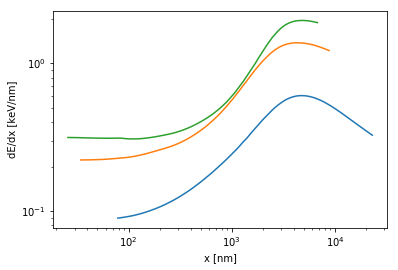

In [18]:
E_Li, dEedx_Li, dEdx_Li, x_Li = np.loadtxt("../Data/dRdESRIM/Li-Zab.txt", usecols=(0,1,2,3), unpack=True)
E_C, dEedx_C, dEdx_C, x_C = np.loadtxt("../Data/dRdESRIM/C-Zab.txt", usecols=(0,1,2,3), unpack=True)
E_O, dEedx_O, dEdx_O, x_O = np.loadtxt("../Data/dRdESRIM/O-Zab.txt", usecols=(0,1,2,3), unpack=True)

x_Li *= 1.e3 # Convert micro_m to nm
x_C *= 1.e3 # Convert micro_m to nm
x_O *= 1.e3 # Convert micro_m to nm

dEdx_Li += dEedx_Li # Convert keV/micro_m to keV/nm
dEdx_C += dEedx_C # Convert keV/micro_m to keV/nm
dEdx_O += dEedx_O # Convert keV/micro_m to keV/nm

dEdx_Li *= 1.e-3 # Convert keV/micro_m to keV/nm
dEdx_C *= 1.e-3 # Convert keV/micro_m to keV/nm
dEdx_O *= 1.e-3 # Convert keV/micro_m to keV/nm

plt.loglog(x_Li, dEdx_Li)
plt.loglog(x_C, dEdx_C)
plt.loglog(x_O, dEdx_O)
plt.ylabel("dE/dx [keV/nm]")
plt.xlabel("x [nm]")
plt.show()

Etox_Li = interp1d(E_Li, x_Li, bounds_error=False, fill_value='extrapolate')
Etox_C = interp1d(E_C, x_C, bounds_error=False, fill_value='extrapolate')
Etox_O = interp1d(E_O, x_O, bounds_error=False, fill_value='extrapolate')

dEdx_Li = interp1d(x_Li, dEdx_Li, bounds_error=False, fill_value='extrapolate')
dEdx_C = interp1d(x_C, dEdx_C, bounds_error=False, fill_value='extrapolate')
dEdx_O = interp1d(x_O, dEdx_O, bounds_error=False, fill_value='extrapolate')

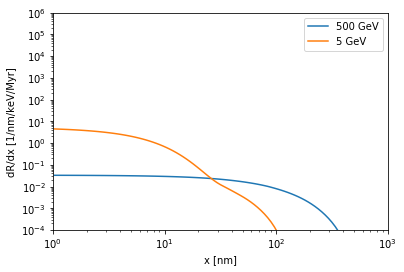

In [23]:
x_bins = np.logspace(0,3,100)
x_width = np.diff(x_bins)
x_c = x_bins[:-1] + x_width/2

dEdxZab = [dEdx_Li,dEdx_C,dEdx_O]
EtoxZab = [Etox_Li,Etox_C,Etox_O]

dEdx_nuclei_Zab = dict(zip(nuclei_Zab, dEdxZab))
Etox_nuclei_Zab = dict(zip(nuclei_Zab, EtoxZab))
ratio_nuclei_Zab = dict(zip(nuclei_Zab, Zab_abun))


def dRdx_Zab(x, E, sigma, m):
    # E in keV, sigma in cm^2, mass in GeV
    dRdx = np.zeros_like(x)
    for i, nuc in enumerate(nuclei_Zab):
        xtemp = Etox_nuclei_Zab[nuc](E)
        dRdx_nuc = DMU.dRdE_standard(E, Zab_p[i], Zab_n[i], m, sigma)*dEdx_nuclei_Zab[nuc](xtemp)
        temp_interp = interp1d(xtemp, dRdx_nuc, bounds_error=False, fill_value='extrapolate')
#         plt.loglog(x,temp_interp(x), label=nuc)
        dRdx += ratio_nuclei_Zab[nuc]*temp_interp(x)
    return dRdx
        
dRdx_Zab500 = dRdx_Zab(x_c, E_list, 1e-45, 500)
dRdx_Zab5 = dRdx_Zab(x_c, E_list, 1e-45, 5)
plt.loglog(x_c, dRdx_Zab500*1e6, label="500 GeV")
plt.loglog(x_c, dRdx_Zab5*1e6, label="5 GeV")
plt.legend()
plt.ylabel("dR/dx [1/nm/keV/Myr]")
plt.xlabel("x [nm]")
plt.ylim(1e-4,1e6)
plt.xlim(1,1000)
plt.show()

# Now lets do Sylvanite

In [24]:
# Sylvanite is Au.75Ag.25Te2 therefore we need to some over several elements to get the signal
# Here we give the number of protons and neutrons in Gold, Silver, and Te
# in that order
nuclei_Syl = ["Au", "Ag", "Te"]
Syl_abun = np.array([0.343,0.0627,0.5936])
Syl_p = np.array([79,47,52])
Syl_n = np.array([118,61,76])

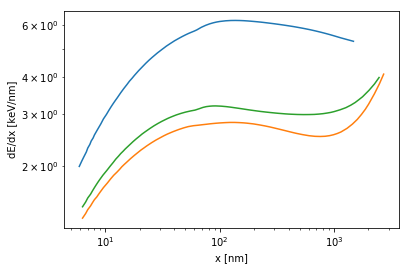

In [25]:
E_Au, dEedx_Au, dEdx_Au, x_Au = np.loadtxt("../Data/dRdESRIM/Au-Syl.txt", usecols=(0,1,2,3), unpack=True)
E_Ag, dEedx_Ag, dEdx_Ag, x_Ag = np.loadtxt("../Data/dRdESRIM/Ag-Syl.txt", usecols=(0,1,2,3), unpack=True)
E_Te, dEedx_Te, dEdx_Te, x_Te = np.loadtxt("../Data/dRdESRIM/Te-Syl.txt", usecols=(0,1,2,3), unpack=True)

x_Au *= 1.e3 # Convert micro_m to nm
x_Ag *= 1.e3 # Convert micro_m to nm
x_Te *= 1.e3 # Convert micro_m to nm

dEdx_Au += dEedx_Au
dEdx_Ag += dEedx_Ag
dEdx_Te += dEedx_Te

dEdx_Au *= 1.e-3 # Convert keV/micro_m to keV/nm
dEdx_Ag *= 1.e-3 # Convert keV/micro_m to keV/nm
dEdx_Te *= 1.e-3 # Convert keV/micro_m to keV/nm

plt.loglog(x_Au, dEdx_Au)
plt.loglog(x_Ag, dEdx_Ag)
plt.loglog(x_Te, dEdx_Te)
plt.ylabel("dE/dx [keV/nm]")
plt.xlabel("x [nm]")
plt.show()

Etox_Au = interp1d(E_Au, x_Au, fill_value='extrapolate')
Etox_Ag = interp1d(E_Ag, x_Ag, fill_value='extrapolate')
Etox_Te = interp1d(E_Te, x_Te, fill_value='extrapolate')

dEdx_Au = interp1d(x_Au, dEdx_Au, fill_value='extrapolate')
dEdx_Ag = interp1d(x_Ag, dEdx_Ag, fill_value='extrapolate')
dEdx_Te = interp1d(x_Te, dEdx_Te, fill_value='extrapolate')

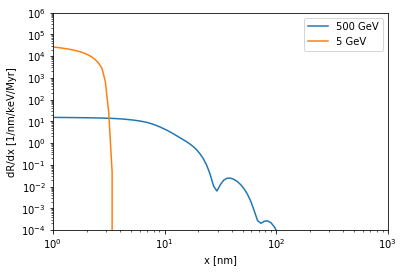

In [29]:
dEdx_Syl = [dEdx_Au,dEdx_Ag,dEdx_Te]
Etox_Syl = [Etox_Au,Etox_Ag,Etox_Te]

dEdx_nuclei_Syl = dict(zip(nuclei_Syl, dEdx_Syl))
Etox_nuclei_Syl = dict(zip(nuclei_Syl, Etox_Syl))
ratio_nuclei_Syl = dict(zip(nuclei_Syl, Syl_abun))

def dRdx_Syl(x, E, sigma, m):
    # E in keV, sigma in cm^2, mass in GeV
    dRdx = np.zeros_like(x)
    for i, nuc in enumerate(nuclei_Syl):
        xtemp = Etox_nuclei_Syl[nuc](E)
        dRdx_nuc = DMU.dRdE_standard(E, Syl_p[i], Syl_n[i], m, sigma)*dEdx_nuclei_Syl[nuc](xtemp)
        temp_interp = interp1d(xtemp, dRdx_nuc, fill_value='extrapolate')
        dRdx += ratio_nuclei_Syl[nuc]*temp_interp(x)
    return dRdx
        
dRdx_Syl500 = dRdx_Syl(x_c, E_list, 1e-45, 500)
dRdx_Syl5 = dRdx_Syl(x_c, E_list, 1e-45, 5)
plt.loglog(x_c, dRdx_Syl500*1e6, label="500 GeV")
plt.loglog(x_c, dRdx_Syl5*1e6, label="5 GeV")
plt.legend()
plt.ylabel("dR/dx [1/nm/keV/Myr]")
plt.xlabel("x [nm]")
plt.ylim(1e-4,1e6)
plt.xlim(1,1000)
plt.show()